In [ ]:
# NETWORK ANOMALY DETECTION FINAL YEAR PROJECT
# -----------------------------
# 1. DATA PREPROCESSING
# -----------------------------
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"/content/traffic_mix.csv"
df = pd.read_csv(file_path)

# Keep only numerical columns
df = df.select_dtypes(include=['float64', 'int64'])
df = df.dropna()

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [ ]:
# -----------------------------
# 2. ISOLATION FOREST MODEL
# -----------------------------
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_model.fit(X_scaled)
iso_preds = iso_model.predict(X_scaled)

# -1 means anomaly, 1 means normal
df['Anomaly_IsolationForest'] = iso_preds

In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest']


In [ ]:
# -----------------------------
# 3. ONE-CLASS SVM
# -----------------------------
# from sklearn.svm import OneClassSVM

# svm_model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
# svm_model.fit(X_scaled)
# svm_preds = svm_model.predict(X_scaled)

# # -1 means anomaly, 1 means normal
# df['Anomaly_OneClassSVM'] = svm_preds

from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.select_dtypes(include='number').dropna())

# Use a subset if still slow
X_sampled = X_scaled[:5000]  # smaller batch

# Train One-Class SVM
ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
ocsvm.fit(X_sampled)

# Predict
predictions = ocsvm.predict(X_sampled)

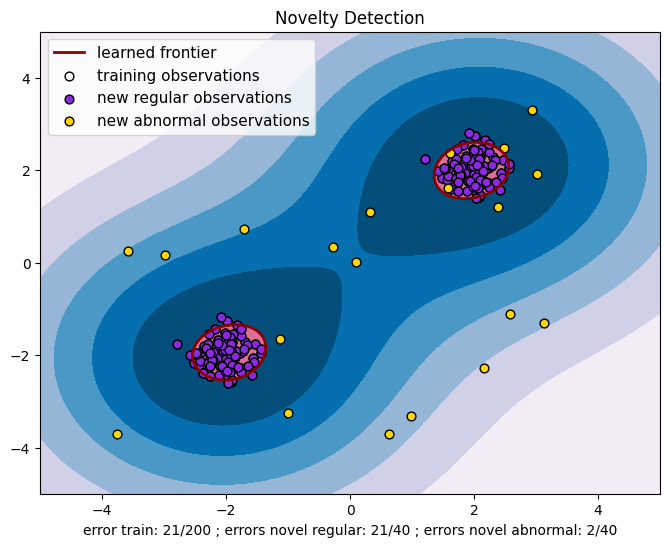

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
import matplotlib.font_manager

# Generate some sample data
np.random.seed(42)
X = 0.3 * np.random.randn(100, 2)
X_train = np.r_[X + 2, X - 2]
X_test = np.r_[X + 2, X - 2]
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))

# Fit the One-Class SVM model
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X_train)

# Predict on the test data
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_outliers = clf.predict(X_outliers)

# Plot the results
xx, yy = np.meshgrid(np.linspace(-5, 5, 500), np.linspace(-5, 5, 500))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.title("Novelty Detection")
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="darkred")
plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors="palevioletred")

s = 40
b1 = plt.scatter(X_train[:, 0], X_train[:, 1], c="white", s=s, edgecolors="k")
b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c="blueviolet", s=s, edgecolors="k")
c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c="gold", s=s, edgecolors="k")

plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
# Explicitly create a Line2D object for the legend
legend_elements = [
    plt.Line2D([0], [0], color='darkred', linewidth=2, label='learned frontier'),
    b1, b2, c
]

plt.legend(
    handles=legend_elements,
    labels=[
        "learned frontier",
        "training observations",
        "new regular observations",
        "new abnormal observations",
    ],
    loc="upper left",
    prop=matplotlib.font_manager.FontProperties(size=11),
)
plt.xlabel(
    "error train: %d/200 ; errors novel regular: %d/40 ; errors novel abnormal: %d/40"
    % (
        (y_pred_train == -1).sum(),
        (y_pred_test == -1).sum(),
        (y_pred_outliers == 1).sum(),
    )
)
plt.show()


In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest']


In [ ]:
# -----------------------------
# 4. AUTOENCODER (DEEP LEARNING)
# -----------------------------
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 14  # or choose smaller

input_layer = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu')(input_layer)
decoded = layers.Dense(input_dim, activation='linear')(encoded)

autoencoder = keras.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=20,
                          batch_size=1000,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

# Reconstruction error
reconstructions = autoencoder.predict(X_scaled)
mse = tf.keras.losses.mse(X_scaled, reconstructions)

# Threshold (mean + std deviation)
thresh = mse.numpy().mean() + mse.numpy().std()
df['Reconstruction_Error'] = mse.numpy()
df['Anomaly_Autoencoder'] = df['Reconstruction_Error'] > thresh


Epoch 1/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2991 - val_loss: 0.2762
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0098 - val_loss: 0.1379
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.1133
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.9606e-04 - val_loss: 0.1117
Epoch 5/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.2754e-04 - val_loss: 0.1099
Epoch 6/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.8042e-04 - val_loss: 0.1087
Epoch 7/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.2443e-04 - val_loss: 0.1071
Epoch 8/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1222e-04 - val_loss: 0.1046
Epoch 9/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.1750e-04 - val_loss: 0.0993
Epoch 10/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.7245e-04 - val_loss: 0.0940
Epoch 11/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.6274e-04 - val_loss: 0.0943
Epoch 12/20
526/526 

In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder']


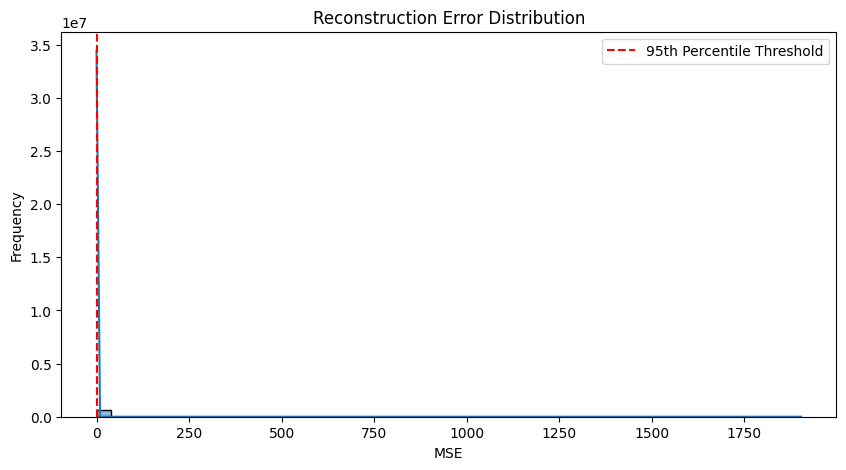

🔍 Autoencoder anomalies detected: 32833


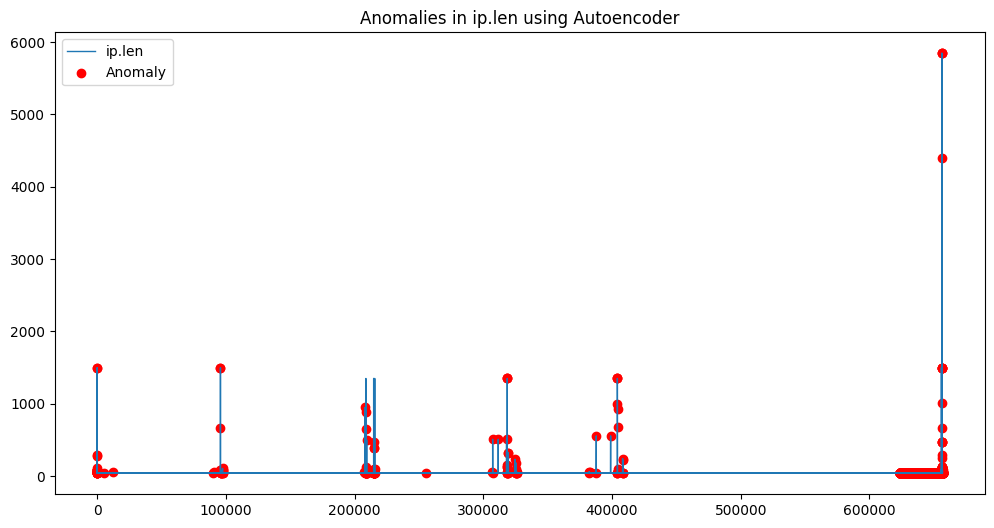

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Optional: plot error distribution to analyze threshold
plt.figure(figsize=(10, 5))
sns.histplot(mse, bins=50, kde=True)
plt.title("Reconstruction Error Distribution")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.axvline(np.percentile(mse, 95), color='red', linestyle='--', label='95th Percentile Threshold')
plt.legend()
plt.show()

# Threshold at 95th percentile
thresh = np.percentile(mse, 95)
df['Reconstruction_Error'] = mse
df['Anomaly_Autoencoder'] = df['Reconstruction_Error'] > thresh

# Show anomaly count
print("🔍 Autoencoder anomalies detected:", df['Anomaly_Autoencoder'].sum())

# Plot anomalies in ip.len
plt.figure(figsize=(12, 6))
plt.plot(df['ip.len'].values, label='ip.len', linewidth=1)
plt.scatter(df[df['Anomaly_Autoencoder']]['ip.len'].index,
            df[df['Anomaly_Autoencoder']]['ip.len'],
            color='red', label='Anomaly', marker='o')
plt.title('Anomalies in ip.len using Autoencoder')
plt.legend()
plt.show()


In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder']


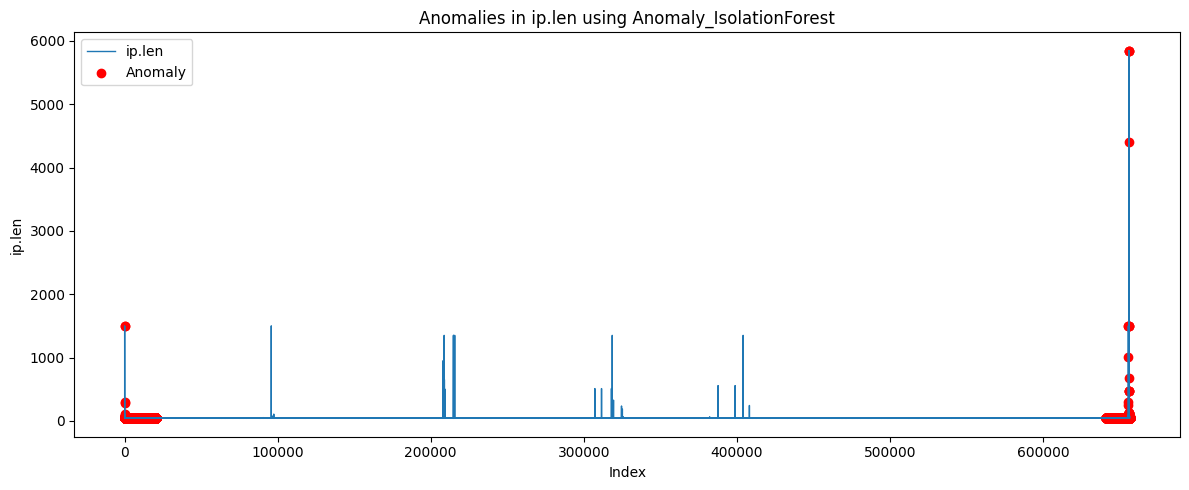

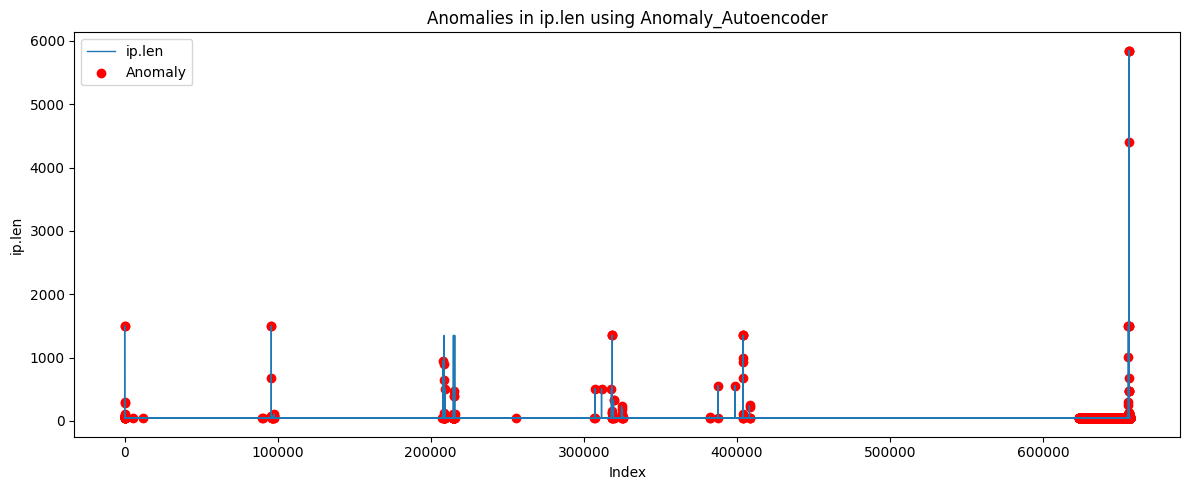

In [ ]:
# -----------------------------
# 5. VISUALIZATION
# -----------------------------
import matplotlib.pyplot as plt


def plot_anomalies(feature='ip.len', method='Anomaly_IsolationForest'):
    plt.figure(figsize=(12, 5))
    plt.plot(df[feature].values, label=feature, linewidth=1)

    if df[method].dtype == 'bool':  # For Autoencoder or Boolean methods
        anomaly_indices = df[df[method]].index
    else:  # For Isolation Forest (-1 means anomaly)
        anomaly_indices = df[df[method] == -1].index

    plt.scatter(anomaly_indices, df.loc[anomaly_indices, feature],
                color='red', label='Anomaly', marker='o')
    plt.title(f"Anomalies in {feature} using {method}")
    plt.xlabel("Index")
    plt.ylabel(feature)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example visualization:
plot_anomalies('ip.len', 'Anomaly_IsolationForest')
# plot_anomalies('ip.len', 'Anomaly_OneClassSVM')
plot_anomalies('ip.len', 'Anomaly_Autoencoder')


In [ ]:
# import pandas as pd
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
# Discretize the data (binarization)
# Here, we label a feature 'High' if above median, else 'Low'
df_bin = df.apply(lambda x: x > x.median())

print("✅ Data prepared for association mining.")


✅ Data prepared for association mining.


In [ ]:
# Apply Apriori Algorithm
frequent_itemsets_apriori = apriori(df_bin, min_support=0.1, use_colnames=True)

# Generate association rules
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1.0)

print("Apriori Rules:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Apriori Rules:
             antecedents            consequents   support  confidence  \
0  (frame.time_relative)               (ip.len)  0.244423    0.488847   
1               (ip.len)  (frame.time_relative)  0.244423    0.501273   
2  (frame.time_relative)        (tcp.flags.ack)  0.244466    0.488932   
3        (tcp.flags.ack)  (frame.time_relative)  0.244466    0.501229   
4        (tcp.flags.ack)               (ip.len)  0.487595    0.999716   

       lift  
0  1.002545  
1  1.002545  
2  1.002457  
3  1.002457  
4  2.050256  


In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder']


In [ ]:
# Apply FP-Growth Algorithm
frequent_itemsets_fpgrowth = fpgrowth(df_bin, min_support=0.1, use_colnames=True)

# Generate association rules
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="lift", min_threshold=1.0)

print("FP-Growth Rules:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

from mlxtend.frequent_patterns import fpgrowth, association_rules

# Print the top frequent patterns
patterns = fpgrowth(df_bin, min_support=0.05, use_colnames=True)
print("\n🔁 Frequent Patterns (FP-Growth):")
print(patterns.head())


# Print rules derived from frequent patterns
rules = association_rules(patterns, metric="confidence", min_threshold=0.7)
print("\n📐 Example Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


FP-Growth Rules:
                                   antecedents             consequents  \
0                       (Reconstruction_Error)         (tcp.flags.ack)   
1                              (tcp.flags.ack)  (Reconstruction_Error)   
2                        (frame.time_relative)         (tcp.flags.ack)   
3                              (tcp.flags.ack)   (frame.time_relative)   
4  (frame.time_relative, Reconstruction_Error)         (tcp.flags.ack)   

    support  confidence      lift  
0  0.275910    0.551820  1.131397  
1  0.275910    0.565699  1.131397  
2  0.244466    0.488932  1.002457  
3  0.244466    0.501229  1.002457  
4  0.103031    0.496842  1.018676  

🔁 Frequent Patterns (FP-Growth):
    support                itemsets
0  0.500000  (Reconstruction_Error)
1  0.487733         (tcp.flags.ack)
2  0.487605                (ip.len)
3  0.050000   (Anomaly_Autoencoder)
4  0.500000   (frame.time_relative)

📐 Example Association Rules:
                             antecedents  

In [ ]:
print(df.columns.tolist())


['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder']


In [ ]:
# Eclat using set intersections manually
def eclat(df, min_support=0.1):
    supports = {}
    items = list(df.columns)
    n_rows = df.shape[0]

    # Single items
    for item in items:
        supports[frozenset([item])] = (df[item].sum()) / n_rows

    # Two-item combinations
    from itertools import combinations
    for itemset in combinations(items, 2):
        support = (df[list(itemset)].all(axis=1).sum()) / n_rows
        if support >= min_support:
            supports[frozenset(itemset)] = support

    return supports

eclat_supports = eclat(df_bin)

print("Manual Eclat Itemsets:")
for k, v in list(eclat_supports.items())[:5]:
    print(f"{set(k)}: {v}")


Manual Eclat Itemsets:
{'frame.time_relative'}: 0.5
{'ip.len'}: 0.4876053824224556
{'ip.proto'}: 0.0
{'tcp.flags.syn'}: 0.0
{'tcp.flags.ack'}: 0.48773330328208375


In [ ]:
# Function to check if a row matches at least one frequent pattern
def matches_patterns(row, frequent_itemsets):
    for itemset in frequent_itemsets['itemsets']:
        if all(row[list(itemset)]):
            return True
    return False

# Mark anomalies
df_bin['is_normal'] = df_bin.apply(lambda row: matches_patterns(row, frequent_itemsets_fpgrowth), axis=1)
df_bin['anomaly'] = ~df_bin['is_normal']

print(f"✅ Total anomalies detected: {df_bin['anomaly'].sum()} out of {len(df_bin)} samples.")

# Show anomaly percentage
print(f"Anomaly Percentage: {100 * df_bin['anomaly'].sum() / len(df_bin):.2f}%")


# Make sure df_bin has same index
df['Anomaly_PatternMining'] = False  # Default to normal
df.loc[df_bin.index, 'Anomaly_PatternMining'] = df_bin['anomaly']


✅ Total anomalies detected: 89951 out of 656656 samples.
Anomaly Percentage: 13.70%


Loading data...
Shape of dataset after selecting numeric columns: (656656, 9)
Running Apriori...
Running FP-Growth...

🔍 Detected anomalies: 89951 out of 656656 records


<ipython-input-19-31bdf544a5be>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='anomaly', data=df_bin, palette='Set1')


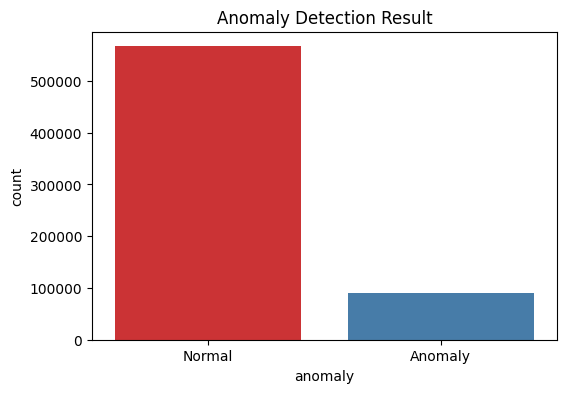


Top Association Rules from Apriori


,antecedents,consequents,support,confidence,lift
0,(frame.time_relative),(ip.len),0.244423,0.488847,1.002545
1,(ip.len),(frame.time_relative),0.244423,0.501273,1.002545
2,(frame.time_relative),(tcp.flags.ack),0.244466,0.488932,1.002457
3,(tcp.flags.ack),(frame.time_relative),0.244466,0.501229,1.002457
4,(tcp.flags.ack),(ip.len),0.487595,0.999716,2.050256



Top Association Rules from FP-Growth


,antecedents,consequents,support,confidence,lift
0,(Reconstruction_Error),(tcp.flags.ack),0.275910,0.551820,1.131397
1,(tcp.flags.ack),(Reconstruction_Error),0.275910,0.565699,1.131397
2,(frame.time_relative),(tcp.flags.ack),0.244466,0.488932,1.002457
3,(tcp.flags.ack),(frame.time_relative),0.244466,0.501229,1.002457
4,"(frame.time_relative, Reconstruction_Error)",(tcp.flags.ack),0.103031,0.496842,1.018676


In [ ]:
# # Install required libraries (if not already installed)
# !pip install mlxtend --quiet

# # Step 1: Load and preprocess
print("Loading data...")

print("Shape of dataset after selecting numeric columns:", df.shape)

print("Running Apriori...")
# apriori_patterns = apriori(df_bin, min_support=min_support, use_colnames=True)
print("Running FP-Growth...")
# fpgrowth_patterns = fpgrowth(df_bin, min_support=min_support, use_colnames=True)

# Step 6: Output and Visualization
print(f"\n🔍 Detected anomalies: {df_bin['anomaly'].sum()} out of {len(df_bin)} records")

# Plot anomaly distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='anomaly', data=df_bin, palette='Set1')
plt.title('Anomaly Detection Result')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

# Show rules
print("\nTop Association Rules from Apriori")
display(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

print("\nTop Association Rules from FP-Growth")
display(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


In [ ]:
print(df.columns.tolist())

['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder', 'Anomaly_PatternMining']


<ipython-input-21-b37ae60100a9>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')


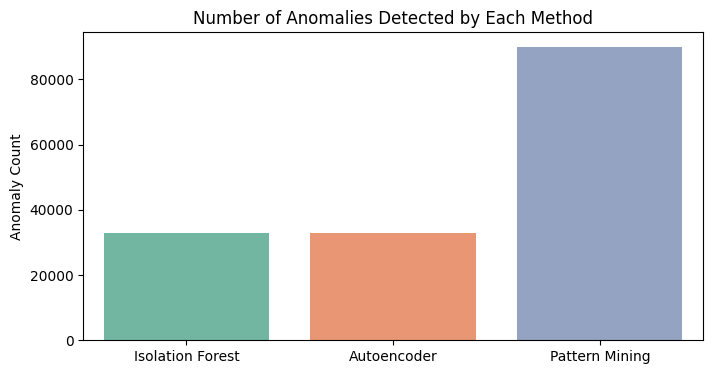

In [ ]:
def plot_anomaly_counts():
    counts = {
        'Isolation Forest': (df['Anomaly_IsolationForest'] == -1).sum(),
        'Autoencoder': df['Anomaly_Autoencoder'].sum(),
        'Pattern Mining': df['Anomaly_PatternMining'].sum()
    }
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')
    plt.title("Number of Anomalies Detected by Each Method")
    plt.ylabel("Anomaly Count")
    plt.show()

plot_anomaly_counts()


✅ Data prepared for association mining.
🔍 Detected anomalies: 89951 out of 656656 records
Anomaly Percentage: 13.70%


<ipython-input-28-aab13445bad9>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Anomaly_PatternMining', data=df, palette='Set1')


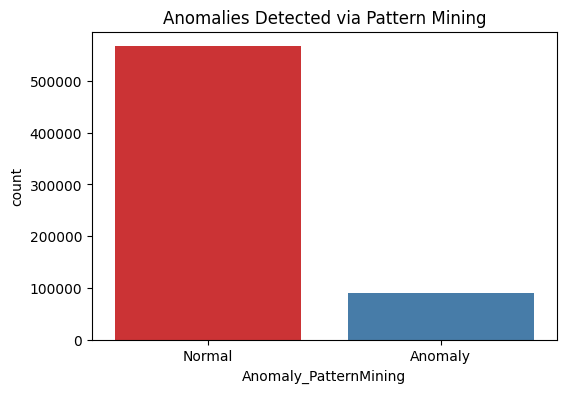


Top Association Rules from Apriori


,antecedents,consequents,support,confidence,lift
0,(frame.time_relative),(ip.len),0.244423,0.488847,1.002545
1,(ip.len),(frame.time_relative),0.244423,0.501273,1.002545
2,(frame.time_relative),(tcp.flags.ack),0.244466,0.488932,1.002457
3,(tcp.flags.ack),(frame.time_relative),0.244466,0.501229,1.002457
4,(tcp.flags.ack),(ip.len),0.487595,0.999716,2.050256



Top Association Rules from FP-Growth


,antecedents,consequents,support,confidence,lift
0,(Reconstruction_Error),(tcp.flags.ack),0.275910,0.551820,1.131397
1,(tcp.flags.ack),(Reconstruction_Error),0.275910,0.565699,1.131397
2,(frame.time_relative),(tcp.flags.ack),0.244466,0.488932,1.002457
3,(tcp.flags.ack),(frame.time_relative),0.244466,0.501229,1.002457
4,"(frame.time_relative, Reconstruction_Error)",(tcp.flags.ack),0.103031,0.496842,1.018676


In [ ]:
# -----------------------------
# 6. PATTERN MINING (ECLAT / APRIORI / FP-GROWTH)
# -----------------------------
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Use the preprocessed df (do NOT reload it again)
# Binarize based on median
df_bin = df.select_dtypes(include=['number']).dropna().apply(lambda x: x > x.median())

print("✅ Data prepared for association mining.")

# --- Apriori ---
frequent_itemsets_apriori = apriori(df_bin, min_support=0.1, use_colnames=True)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1.0)

# --- FP-Growth ---
frequent_itemsets_fpgrowth = fpgrowth(df_bin, min_support=0.1, use_colnames=True)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="lift", min_threshold=1.0)

# --- Manual ECLAT ---
def eclat(df, min_support=0.1):
    supports = {}
    items = list(df.columns)
    n_rows = df.shape[0]

    from itertools import combinations
    for item in items:
        supports[frozenset([item])] = df[item].sum() / n_rows
    for itemset in combinations(items, 2):
        support = df[list(itemset)].all(axis=1).sum() / n_rows
        if support >= min_support:
            supports[frozenset(itemset)] = support
    return supports

eclat_supports = eclat(df_bin)

# --- Mark pattern-based anomalies ---
# def matches_patterns(row, frequent_itemsets):
#     for itemset in frequent_itemsets['itemsets']:
#         if all(row[list(itemset)]):
#             return True
#     return False

df_bin['is_normal'] = df_bin.apply(lambda row: matches_patterns(row, frequent_itemsets_fpgrowth), axis=1)
df_bin['anomaly'] = ~df_bin['is_normal']

# ✅ Merge pattern-based anomalies into main df
df['Anomaly_PatternMining'] = False  # Default: normal
df.loc[df_bin.index, 'Anomaly_PatternMining'] = df_bin['anomaly']  # Update where applicable

# --- Visualization ---
print(f"🔍 Detected anomalies: {df['Anomaly_PatternMining'].sum()} out of {len(df)} records")
print(f"Anomaly Percentage: {100 * df['Anomaly_PatternMining'].sum() / len(df):.2f}%")

plt.figure(figsize=(6, 4))
sns.countplot(x='Anomaly_PatternMining', data=df, palette='Set1')
plt.title('Anomalies Detected via Pattern Mining')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

# Optional: Show rules
print("\nTop Association Rules from Apriori")
display(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

print("\nTop Association Rules from FP-Growth")
display(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Patterns used by them

In [ ]:
from sklearn.ensemble import IsolationForest

# Fit the model
model = IsolationForest()
model.fit(X)

# Get anomaly scores (the lower, the more anomalous)
scores = model.decision_function(X)
threshold = model.threshold_ if hasattr(model, 'threshold_') else np.percentile(scores, 5)

# Print a sample of scores
print("📊 Isolation Forest Anomaly Scores:")
for i, score in enumerate(scores[:300]):
    print(f"Row {i}: Score = {score:.4f} | {'Anomaly' if score < threshold else 'Normal'}")


📊 Isolation Forest Anomaly Scores:
Row 0: Score = 0.0673 | Normal
Row 1: Score = 0.0031 | Normal
Row 2: Score = 0.0921 | Normal
Row 3: Score = -0.0809 | Normal
Row 4: Score = 0.0838 | Normal
Row 5: Score = 0.0801 | Normal
Row 6: Score = -0.0283 | Normal
Row 7: Score = -0.0527 | Normal
Row 8: Score = 0.0578 | Normal
Row 9: Score = -0.0006 | Normal
Row 10: Score = -0.0425 | Normal
Row 11: Score = 0.0337 | Normal
Row 12: Score = 0.0775 | Normal
Row 13: Score = 0.0544 | Normal
Row 14: Score = 0.0884 | Normal
Row 15: Score = -0.0524 | Normal
Row 16: Score = 0.0445 | Normal
Row 17: Score = 0.0158 | Normal
Row 18: Score = -0.0339 | Normal
Row 19: Score = 0.0336 | Normal
Row 20: Score = 0.0465 | Normal
Row 21: Score = 0.0840 | Normal
Row 22: Score = 0.0007 | Normal
Row 23: Score = 0.0450 | Normal
Row 24: Score = -0.0316 | Normal
Row 25: Score = 0.0734 | Normal
Row 26: Score = 0.0729 | Normal
Row 27: Score = -0.0032 | Normal
Row 28: Score = 0.0789 | Normal
Row 29: Score = 0.0679 | Normal
Row 30

In [ ]:
from sklearn.svm import OneClassSVM

# Fit the model
ocsvm = OneClassSVM(kernel='rbf', gamma='scale')
ocsvm.fit(X)

# Decision function and prediction
scores = ocsvm.decision_function(X)
preds = ocsvm.predict(X)

# Print anomaly boundary
print("\n🧭 One-Class SVM Decision Scores:")
for i, (score, pred) in enumerate(zip(scores[:10], preds[:10])):
    print(f"Row {i}: Score = {score:.4f} | {'Anomaly' if pred == -1 else 'Normal'}")



🧭 One-Class SVM Decision Scores:
Row 0: Score = 0.0588 | Normal
Row 1: Score = -0.8619 | Anomaly
Row 2: Score = 0.0828 | Normal
Row 3: Score = -2.8092 | Anomaly
Row 4: Score = 0.2156 | Normal
Row 5: Score = 0.2859 | Normal
Row 6: Score = -2.5543 | Anomaly
Row 7: Score = -2.1569 | Anomaly
Row 8: Score = 0.2958 | Normal
Row 9: Score = -1.7595 | Anomaly


In [ ]:
# Predict reconstruction
reconstructions = autoencoder.predict(X_scaled)
reconstruction_errors = np.mean(np.square(X_scaled - reconstructions), axis=1)

# Print error threshold
threshold = np.percentile(reconstruction_errors, 95)

print("\n🧠 Autoencoder Reconstruction Errors:")
for i, err in enumerate(reconstruction_errors[:10]):
    print(f"Row {i}: Error = {err:.5f} | {'Anomaly' if err > threshold else 'Normal'}")


20521/20521 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step

🧠 Autoencoder Reconstruction Errors:
Row 0: Error = 0.07206 | Anomaly
Row 1: Error = 0.07566 | Anomaly
Row 2: Error = 0.09147 | Anomaly
Row 3: Error = 1.46810 | Anomaly
Row 4: Error = 1.46810 | Anomaly
Row 5: Error = 0.04263 | Anomaly
Row 6: Error = 0.07407 | Anomaly
Row 7: Error = 0.04401 | Anomaly
Row 8: Error = 0.08981 | Anomaly
Row 9: Error = 0.08463 | Anomaly


In [ ]:
from sklearn.ensemble import IsolationForest

# Assuming df is already preprocessed and contains numeric data
isf_model = IsolationForest(contamination=0.05, random_state=42)
df['Anomaly_IsolationForest'] = isf_model.fit_predict(df)

# Convert from (-1, 1) to (1 for anomaly, 0 for normal)
df['Anomaly_IsolationForest'] = df['Anomaly_IsolationForest'].apply(lambda x: 1 if x == -1 else 0)


<ipython-input-26-e4a51085a7e0>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')


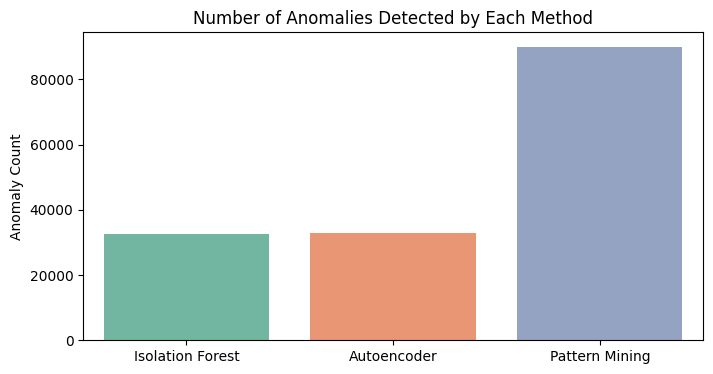

['frame.time_relative', 'ip.len', 'ip.proto', 'tcp.flags.syn', 'tcp.flags.ack', 'Anomaly_IsolationForest', 'Reconstruction_Error', 'Anomaly_Autoencoder', 'Anomaly_PatternMining']


In [ ]:
from mlxtend.frequent_patterns import fpgrowth, association_rules




def plot_anomaly_counts():
    counts = {
        'Isolation Forest': df['Anomaly_IsolationForest'].sum(),
        'Autoencoder': df['Anomaly_Autoencoder'].sum(),
        'Pattern Mining': df['Anomaly_PatternMining'].sum()
    }
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette='Set2')
    plt.title("Number of Anomalies Detected by Each Method")
    plt.ylabel("Anomaly Count")
    plt.show()

plot_anomaly_counts()
print(df.columns.tolist())
